In [1]:
import numpy as np
import cirq
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from openparticle import ParticleOperator, Fock
from openparticle.utils import generate_matrix, get_fock_basis
import math
from functools import reduce, partial
from symmer import QuantumState

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../'))

from src.lobe.fermionic import fermionic_product_block_encoding, fermionic_plus_hc_block_encoding
from src.lobe.system import System
from src.lobe.metrics import CircuitMetrics
from src.lobe.multiplexed_rotations import get_decomposed_multiplexed_rotation_circuit
from src.lobe._utils import _apply_negative_identity, get_basis_of_full_system, get_fermionic_operator_types
from src.lobe.bosonic import _get_bosonic_rotation_angles, _add_multi_bosonic_rotations
from src.lobe.addition import add_classical_value
from src.lobe.decompose import decompose_controls_left, decompose_controls_right
from src.lobe.index import index_over_terms
from src.lobe.asp import add_prepare_circuit, get_target_state
from src.lobe.reflection import add_ancilla_reflection
from src.lobe.qpe_utils import *

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
Zero = np.array([1, 0])
One = np.array([0, 1])

### Define the Hamiltonian

In [14]:
hamiltonian_operator = (
    ParticleOperator('b0^ b0') + 2 * ParticleOperator('b1^ b1')
    #+ParticleOperator('b1^ b0^') + ParticleOperator('b0 b1')
)

basis = get_basis_of_full_system(1, 2, 0)
H_matrix = generate_matrix(hamiltonian_operator, basis)
print("Matrix:\n", H_matrix.real)
vals, vecs = np.linalg.eigh(H_matrix)
print("Eigenvalues:", vals)

print("Eigenvectors:\n", vecs)

Matrix:
 [[0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 3.]]
Eigenvalues: [0. 1. 2. 3.]
Eigenvectors:
 [[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [4]:
def get_select_oracle(
        operator,
        prepare_register,
        system,
        block_encoding_ancillae,
        clean_ancillae,
        ctrls = ([], [])
):
    
    block_encoding_functions = []
    for group in operator.group():
        
        active_modes, operator_types = get_fermionic_operator_types(group.to_list()[0])
        sign = np.sign(group.to_list()[-1].coeff)
        if len(group) == 1:
            block_encoding_functions.append(
                partial(
                    fermionic_product_block_encoding,
                    system=system,
                    block_encoding_ancillae=block_encoding_ancillae,
                    active_indices=active_modes,
                    operator_types=operator_types,
                    sign = sign,
                    clean_ancillae=clean_ancillae[1:],
                    ctrls = ctrls,
                )
            )
        elif len(group) == 2:
            block_encoding_functions.append(
                partial(
                    fermionic_plus_hc_block_encoding,
                    system=system,
                    block_encoding_ancillae=block_encoding_ancillae,
                    active_indices=active_modes,
                    operator_types=operator_types,
                    sign = sign,
                    clean_ancillae=clean_ancillae[1:],
                    ctrls = ctrls,
                )
            )

    select = index_over_terms(index_register=prepare_register, block_encoding_functions=block_encoding_functions,
                              clean_ancillae=clean_ancillae[1:], ctrls = ctrls)
    return select

In [89]:
clean_ancillae = [cirq.LineQubit(-1-i) for i in range(10)]
index_register = [cirq.LineQubit(i) for i in range(int(np.ceil(np.log2(len(hamiltonian_operator.group())))))]
block_encoding_ancilla = [cirq.LineQubit(len(index_register) + 1)]

system = System(1, len(clean_ancillae) + len(index_register) + len(block_encoding_ancilla),
                  hamiltonian_operator.max_mode + 1, 0)


SELECT = get_select_oracle(
    operator = hamiltonian_operator,
    prepare_register=index_register,
    system = system,
    block_encoding_ancillae=block_encoding_ancilla,
    clean_ancillae=clean_ancillae,
)

coefficient_vector = [term.coeff if len(term) == 1 else term.coeffs[0] for term in hamiltonian_operator.group()]
rescaling_factor = np.linalg.norm(coefficient_vector, 1)
target_state = get_target_state(coefficients=coefficient_vector)
PREPARE = add_prepare_circuit(index_register, target_state=target_state)[0]

REFLECT = add_ancilla_reflection(ancilla_register=index_register)
PREPARE_DAGGER = [cirq.inverse(gate) for gate in PREPARE[::-1]]

# W = REFLECT + PREPARE + SELECT + PREPARE_DAGGER
W = SELECT + PREPARE_DAGGER + REFLECT + PREPARE

In [90]:
cirq.Circuit(W)

-2: ───X─────@─────X─────X───@─────X──────────────────────────────────
       │     │     │     │   │     │
0: ────(0)───┼─────(0)───@───┼─────@───Ry(-0.608π)───Z───Ry(0.608π)───
             │               │
2: ──────────X───────────────X────────────────────────────────────────
             │               │
12: ─────────(0)─────────────┼────────────────────────────────────────
                             │
13: ─────────────────────────(0)──────────────────────────────────────

In [418]:
W_matrix = cirq.Circuit(W).unitary()
W_eigvals, W_eigvecs = np.linalg.eig(W_matrix)
for eigval in W_eigvals:
    print(rescaling_factor * np.cos(np.angle(eigval)))

3.0
-3.0
-1.0
-1.0000000000000009
3.0
-3.0
-3.0
0.9999999999999993
0.9999999999999998
3.0
3.0
-1.0
-3.0
-1.0
3.0
0.9999999999999998
0.9999999999999998
3.0
-3.0
-3.0
3.0
-3.0
3.0
-3.0
3.0
3.0
-3.0
-3.0
3.0
3.0
-3.0
-3.0


### Verify oracles

In [15]:
rescaled_vals = vals / rescaling_factor
print("Rescaled Eigenvalues:", rescaled_vals)

Rescaled Eigenvalues: [0.         0.33333333 0.66666667 1.        ]


In [94]:
H_matrix.real

array([[0., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 3.]])

In [95]:
cirq.Circuit([PREPARE, SELECT, PREPARE_DAGGER]).unitary()[:4, :4].real * rescaling_factor

array([[0., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 3.]])

In [96]:
cirq.Circuit([PREPARE, SELECT, PREPARE_DAGGER]).unitary()[:4, :4].imag

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [97]:
cirq.Circuit([PREPARE, SELECT, SELECT, PREPARE_DAGGER]).unitary()[:4, :4].real

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

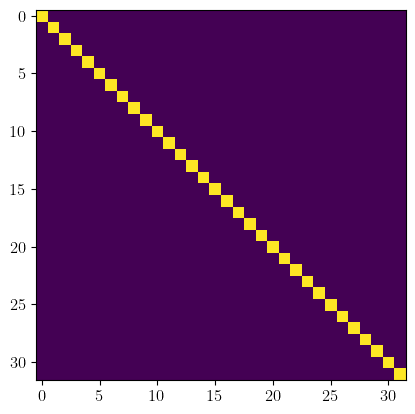

In [98]:
plt.imshow(cirq.Circuit([PREPARE, SELECT, SELECT, PREPARE_DAGGER]).unitary().real)

### QPE

In [133]:
initial_state = np.kron(
                        np.array([1, 0, 0, 0], dtype=complex),
                        np.kron(
                            target_state,
                            np.kron(
                                [1, 0],
                                system_state
                            )
                        )
                )
initial_state.dot(cirq.Circuit(W).unitary().dot(initial_state.T.conj()))

ValueError: shapes (32,32) and (64,1) not aligned: 32 (dim 1) != 64 (dim 0)

In [143]:
w_vals, w_vecs = np.linalg.eig(cirq.Circuit(W).unitary())
w_vals

array([ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
       -7.45355992e-01-6.66666667e-01j,  7.45355992e-01-6.66666667e-01j,
        7.45355992e-01+6.66666667e-01j, -3.33333333e-01+9.42809042e-01j,
       -7.45355992e-01+6.66666667e-01j, -3.33333333e-01+9.42809042e-01j,
       -3.33333333e-01+9.42809042e-01j,  3.33333333e-01+9.42809042e-01j,
        3.33333333e-01-9.42809042e-01j, -3.33333333e-01-9.42809042e-01j,
        8.53850938e-01+5.20517604e-01j,  8.53850938

In [150]:
rescaling_factor * np.cos(np.angle(w_vals))

array([ 3.00000000e+00,  3.00000000e+00,  3.00000000e+00,  3.00000000e+00,
        3.00000000e+00,  3.00000000e+00,  3.00000000e+00,  3.00000000e+00,
        3.00000000e+00,  3.00000000e+00,  3.00000000e+00,  3.00000000e+00,
        3.00000000e+00,  3.00000000e+00,  3.00000000e+00,  3.00000000e+00,
       -2.23606798e+00,  2.23606798e+00,  2.23606798e+00, -1.00000000e+00,
       -2.23606798e+00, -1.00000000e+00, -1.00000000e+00,  1.00000000e+00,
        1.00000000e+00, -1.00000000e+00,  2.56155281e+00,  2.56155281e+00,
        1.83697020e-16, -1.56155281e+00,  8.49830835e-16, -1.56155281e+00,
       -3.00000000e+00, -1.00000000e+00, -2.00000000e+00, -2.00000000e+00,
       -2.00000000e+00, -1.00000000e+00, -2.00000000e+00,  3.00000000e+00,
        3.00000000e+00,  1.00000000e+00,  1.00000000e+00,  3.00000000e+00,
       -3.00000000e+00, -3.00000000e+00, -3.00000000e+00,  1.00000000e+00,
        1.00000000e+00, -3.00000000e+00,  3.00000000e+00,  3.00000000e+00,
        3.00000000e+00, -

In [138]:
np.cos(0.13807119)*rescaling_factor, vals[0]

(2.971449918741069, -0.4142135623730951)

In [149]:
for i in range(len(w_vecs)):
    eigenstate = w_vecs[:, i]
    overlap = np.dot(eigenstate.T.conj(), initial_state.reshape(128))
    if np.abs(overlap)**2 > 1e-12:
        print(np.abs(overlap)**2)

0.0064145877436857
0.2435854122563139
0.24358541225631417
0.21338834764831838
0.006414587743685754
0.000232867394034889
0.004140746016911236
0.21273568544317556
0.04703283194183587
0.0004232631028887516
0.0017372937382726752
0.014629945102952345
0.006925583030457964
0.004495132196797757
5.2849108993461664e-05
0.00021811768948306871
0.000262948289847497
7.1395440812555135e-06
2.1321758735955806e-05
5.066871559742703e-06
9.288187147920448e-09
4.6227585889765856e-07
5.6924716180569745e-11
5.3513128182243275e-12
2.0854592093347195e-11


In [132]:
np.exp(1j*np.arccos(vals[0]/rescaling_factor))

(-0.13807118745769825+0.9904223075002002j)

In [99]:
eigenstate = 2
n_phase_bits = 4

W_circuit = cirq.CircuitOperation(cirq.Circuit(W).freeze())
n_qubits_W = cirq.num_qubits(cirq.Circuit(W))
n_clean_qubits = (cirq.num_qubits(cirq.Circuit(W)) - len(block_encoding_ancilla) - len(index_register) - system.number_of_system_qubits)

phase_register = [cirq.LineQubit(i) for i in range(-100, -100 + n_phase_bits)]

qpe = []

#Initial state 
phase_state = np.zeros(1<<n_phase_bits) 
phase_state[0] = 1 #|0>^o\times n_phase_bits

prep = [Zero] * len(index_register) #|0>^\otimes n_index_qubits
be_ancillae_state = [Zero] * len(block_encoding_ancilla) #|0>^\otimes n_be_ancillae
clean_ancilla_state = [Zero] * n_clean_qubits
system_state = [vecs[:, eigenstate]]

initial_unitary_register_state = np.kron(
    clean_ancilla_state, np.kron(
        prep, np.kron(
            be_ancillae_state, system_state
        )
    )
)

full_initial_state = np.kron(phase_state, initial_unitary_register_state)

    


initial_state_vector = QuantumState.from_array(full_initial_state.reshape([-1, 1]))
print("Initial state:\n", initial_state_vector)
print("Intial state overlap: ",initial_state_vector.dagger * initial_state_vector)


Initial state:
  1.000+0.000j |000000001>
Intial state overlap:  (1+0j)


In [128]:
qpe = []
qpe += [PREPARE]
qpe += [cirq.Moment(cirq.H.on_each(*phase_register))]

for j, control_qubit in enumerate(phase_register[::-1]):
    power = 2**j
    W_power = W_circuit.repeat(power)
    controlled_block = W_power.controlled_by(control_qubit) 
    qpe.append(controlled_block)

qpe += [cirq.qft(*phase_register, inverse=True)]

qpe_circuit = cirq.Circuit(qpe)

In [183]:
hamiltonian_operator = (
    ParticleOperator('b0^ b0') +  ParticleOperator('b1^ b1')
    +ParticleOperator('b0^ b1') + ParticleOperator('b1^ b0')
)
basis = get_basis_of_full_system(1, 2, 0)
H_matrix = generate_matrix(hamiltonian_operator, basis)
vals, vecs = np.linalg.eigh(H_matrix)

n_phase_bits = 6

#Registers: phase reg, index, clean/be ancillae, system
# qubit_registers = [n_phase_bits, int(np.ceil(np.log2(len(hamiltonian_operator.group())))), ]


qubits = [cirq.LineQubit(i) for i in range(n_phase_bits + 6)]
phase_register = qubits[:n_phase_bits]
index_register = qubits[n_phase_bits: n_phase_bits + 1]
clean_ancilla_register = qubits[n_phase_bits + 1: n_phase_bits + 3]
block_encoding_ancilla_register = qubits[n_phase_bits + 3:n_phase_bits + 4]
system_register = qubits[n_phase_bits + 4:]

circuit = cirq.Circuit()
circuit.append(cirq.I.on_each(*qubits))

for qubit in phase_register:
    circuit.append(cirq.H.on(qubit))


coefficient_vector = [term.coeff if len(term) == 1 else term.coeffs[0] for term in hamiltonian_operator.group()]
rescaling_factor = np.linalg.norm(coefficient_vector, 1)
target_state = get_target_state(coefficients=coefficient_vector)

system = System(1, len(phase_register) + len(index_register) + len(clean_ancilla_register) + len(block_encoding_ancilla_register), hamiltonian_operator.max_mode + 1, 0)
assert system.fermionic_modes == system_register

for i, qubit in enumerate(phase_register[::-1]):
    for _ in range(1<<i):
        prepare_gates, _ = add_prepare_circuit(index_register, target_state, dagger=False, clean_ancillae=clean_ancilla_register, ctrls=([qubit], [1]))
        circuit += prepare_gates
        
        select_gates, _ = get_select_oracle(
            operator = hamiltonian_operator,
            prepare_register=index_register,
            system = system,
            block_encoding_ancillae=block_encoding_ancilla_register,
            clean_ancillae=clean_ancilla_register,
            ctrls=([qubit], [1])
        )
        circuit += select_gates

        prepare_dagger_gates, _ = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancilla_register, ctrls=([qubit], [1]))
        circuit += prepare_dagger_gates
        
        refl_gates = add_ancilla_reflection(index_register+block_encoding_ancilla_register, ctrls=([qubit], [1]))
        circuit += refl_gates

circuit.append(cirq.qft(*phase_register, inverse=True))

$e^{i\theta}\to e^{i 2\pi  \phi}$ s.t. $\phi \in [0, 1]$ $\textit{or}$ $e^{i \pi \phi}$ s.t. $\phi \in [-1, 1]$

$\pi \phi = \arccos(\lambda / \alpha)$

In [185]:
# Just some faster code to sample the measurements of the phase register in the infinite sample limit
def simulate_circuit_and_compute_probabilities(circuit, initial_state, bop):
    state = cirq.Simulator().simulate(circuit, initial_state=initial_state).final_state_vector
    traced_phase_reg_probabilities = np.zeros(1<<bop)
    for index in range(1 << len(circuit.all_qubits())):
        amp = state[index]
        prob = np.abs(amp)**2
        full_basis_state = format(index, "0{}b".format(len(circuit.all_qubits())))
        state_of_phase_reg = full_basis_state[:bop]
        traced_phase_reg_probabilities[int(state_of_phase_reg, 2)] += prob
    traced_phase_reg_probabilities = np.concatenate([traced_phase_reg_probabilities[-1<<(bop-1):], traced_phase_reg_probabilities[:1<<(bop-1)]])
    return traced_phase_reg_probabilities

# Relationship between measurement outcomes and eigenphase
def list_possible_eigenphases(bop):
    eigenphases = []
    for index in range(1 << bop):
        eigenphase = (index / (1 << (bop-1)))
        if eigenphase >= 1:
            eigenphase -= 2
        eigenphases.append(eigenphase)
    return sorted(eigenphases)

def expected_value_of_eigenphase(eigenphases, phase_reg_probabilities):
    exp_val = 0
    for eigenphase, probability in zip(eigenphases, phase_reg_probabilities):
        exp_val += eigenphase*probability
    return exp_val

def decode_eigenphase(eigenphase, alpha):
    return -alpha * np.cos(eigenphase*np.pi)

In [186]:
from src.lobe._utils import pretty_print

excitation_level = 2
#Initial state 
phase_state = np.zeros(1<<n_phase_bits) 
phase_state[0] = 1 #|0>^o\times n_phase_bits

index_clean_be_anc = np.zeros(1 << (1 + 2 + 1))
index_clean_be_anc[0] = 1
system_state = vecs[:, excitation_level]

full_initial_state = np.kron(
    phase_state.flatten(),
    np.kron(
        index_clean_be_anc.flatten(), system_state.flatten()
    )
)

print("---Initial---")
print(pretty_print(full_initial_state.flatten(), [n_phase_bits, 1, 2, 1, 2], 1e-4))

state = cirq.Simulator().simulate(circuit, initial_state=full_initial_state.flatten()).final_state_vector
print("---Final---")
print(pretty_print(state, [n_phase_bits, 1, 2, 1, 2], 1e-4))

---Initial---
(1+0j)           |000000|0|00|0|10>

---Final---
(0.016+0j)       |000000|0|00|0|10>
(0.016+0.001j)   |000001|0|00|0|10>
-0j              |000001|0|00|1|10>
(-0+0j)          |000001|1|00|0|10>
-0j              |000001|1|00|1|10>
(0.016+0.002j)   |000010|0|00|0|10>
-0.001j          |000010|0|00|1|10>
(-0+0.001j)      |000010|1|00|0|10>
-0.001j          |000010|1|00|1|10>
(0.016+0.002j)   |000011|0|00|0|10>
-0.001j          |000011|0|00|1|10>
(-0+0.001j)      |000011|1|00|0|10>
-0.001j          |000011|1|00|1|10>
(0.016+0.003j)   |000100|0|00|0|10>
-0.001j          |000100|0|00|1|10>
(-0+0.001j)      |000100|1|00|0|10>
-0.001j          |000100|1|00|1|10>
(0.016+0.004j)   |000101|0|00|0|10>
-0.001j          |000101|0|00|1|10>
(-0+0.001j)      |000101|1|00|0|10>
-0.001j          |000101|1|00|1|10>
(0.016+0.005j)   |000110|0|00|0|10>
-0.002j          |000110|0|00|1|10>
(-0+0.002j)      |000110|1|00|0|10>
-0.002j          |000110|1|00|1|10>
(0.016+0.006j)   |000111|0|00|0|10>
(

In [187]:
probabilities = simulate_circuit_and_compute_probabilities(circuit, full_initial_state, n_phase_bits)
eigenphases = list_possible_eigenphases(n_phase_bits)


Text(0.5, 1.0, '$|E> =  1.000+0.000j |10>, E = 1.0, \\arccos (-E/\\alpha) = 0.732 \\pi$')

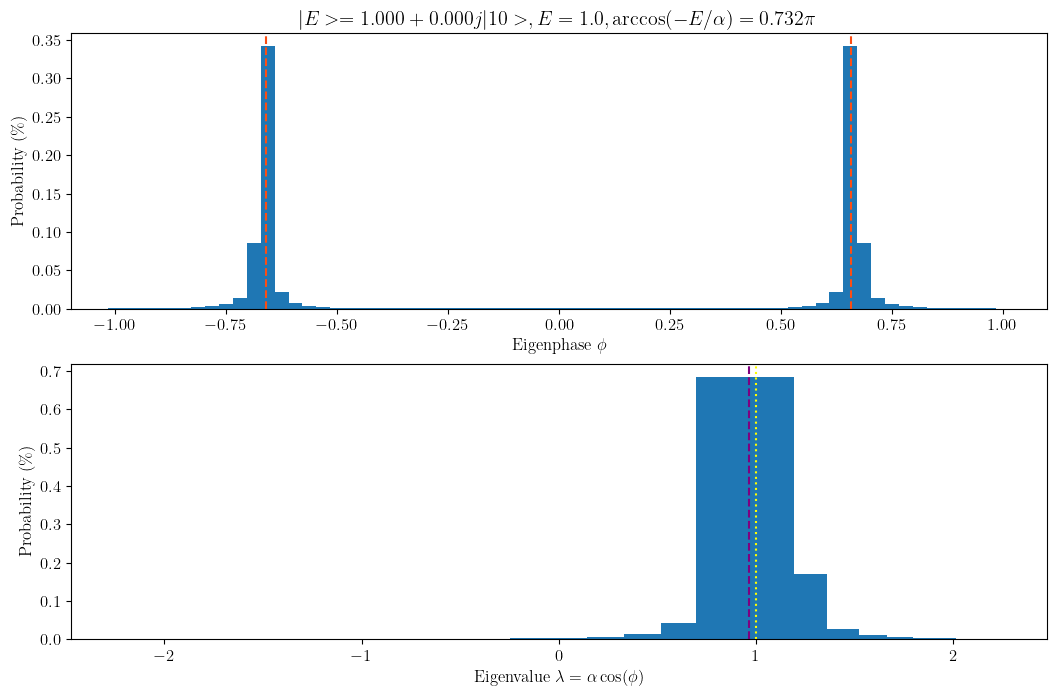

In [188]:
fig, axes = plt.subplots(2, 1, figsize=(32 / 2.54, 20 / 2.54))

# axes[0].bar(names, counts, width = 0.02)
axes[0].bar(eigenphases, probabilities, width=2/(1<<n_phase_bits))

alpha_plot_scale = 0
if n_phase_bits < 5:
    alpha_plot_scale = 0.75

for possible_eigenphase in eigenphases:
    axes[0].axvline(x = possible_eigenphase, color = 'k', linestyle = ':', alpha = alpha_plot_scale, zorder = -1)
axes[0].set_ylabel(r'Probability ($\%$)')
axes[0].set_xlabel(f"Eigenphase $\phi$")
axes[0].set_xlim(-1.1, 1.1)
# axes[0].set_ylim(0, 100)
negative_numerical_value = expected_value_of_eigenphase(eigenphases[:int(len(eigenphases)/2)], 2*probabilities[:int(len(eigenphases)/2)])
positive_numerical_value = expected_value_of_eigenphase(eigenphases[int(len(eigenphases)/2):], 2*probabilities[int(len(eigenphases)/2):])
axes[0].axvline(x=positive_numerical_value, color="#FC4E14", ls="--", label="Numerical")
axes[0].axvline(x=negative_numerical_value, color="#FC4E14", ls="--", label="Numerical")


energies = np.array([decode_eigenphase(eigenphase, rescaling_factor) for eigenphase in eigenphases]) #-1*np.cos(np.array(eigenphases)*np.pi)
parsed_energies = energies[:int(len(energies)/2) + 1]
parsed_probabilities = np.array(probabilities[:int(len(energies)/2) + 1])
for i, prob in enumerate(probabilities[int(len(energies)/2) + 1:]):
    parsed_probabilities[-2 - i] += prob
bar_plot = axes[1].bar(parsed_energies, parsed_probabilities, width=32/(1<<n_phase_bits))

axes[1].set_ylabel(r'Probability ($\%$)')
axes[1].set_xlabel(r"Eigenvalue $\lambda = \alpha \cos(\phi)$")

estimated_energy = np.average(
    [decode_eigenphase(positive_numerical_value, rescaling_factor),
    decode_eigenphase(negative_numerical_value, rescaling_factor)]
)
axes[1].axvline(x=estimated_energy, color="purple", ls="--", label="Numerical Average")
axes[1].axvline(x=vals[excitation_level], color="yellow", ls=":", label="Analytical Expectation")

axes[0].set_title(f"$|E> = {QuantumState.from_array(vecs[:, excitation_level].reshape(-1, 1))}, E = {vals[excitation_level].round(3)}, \\arccos (-E/\\alpha) = {(np.arccos(-rescaled_vals[excitation_level])/np.pi).round(3)} \\pi$")

# plt.tight_layout()
